# 🎮 Monitoring a Real-world Example of Data and Model Drift

In this tutorial, we'll explore a typical real-world scenario and workflow where data and model drift often occur, and we'll demonstrate how to effectively monitor these changes using different tools like *Argilla*, *Ollama*, *BerTopic* or *TextDescriptives*.

The steps we'll follow are:

* Prepare the example dataset
* Fine-tune the classifier with the historical data
* Simulate data drift using *Gemma* from *Ollama*
* Show how to monitor data drift using *Argilla*
* Analyze data drift using *BerTopic* and *TextDescriptives*

## Introduction

Training a machine learning model requires a significant amount of data. Therefore, practitioners typically use current datasets to train the model until it reaches a satisfactory quality. Over time, however, the performance of a model can begin to degrade, a phenomenon known as **model drift**. Understanding why this happens is critical to effectively dealing with the problem.

One of the main causes of model drift is **data drift**, which refers to changes in data distribution or statistics over time. When a model encounters new data that differs from its training set, its predictive accuracy can deteriorate. For example, because of changes in language and email formats, a spam classifier trained a decade ago may not be able to accurately categorize email today.

Identifying data drift as early as possible is therefore essential. Doing so requires identifying the two main types of data drift:

1. **Concept drift**: This occurs when the relationship between input data and output changes, rendering previous associations irrelevant. Over time, certain concepts may change in meaning, affecting their weight in the model's computations. Concept drift can manifest itself in several ways, including
   - Sudden drift, where a new concept emerges abruptly. This is exemplified by the emergence of COVID-19.
   - Gradual drift, where a new concept gradually and alternatively integrates with existing ones.
   - Incremental drift, where a new concept becomes established slowly over time.
   - Recurring concepts, where previously encountered concepts reappear.

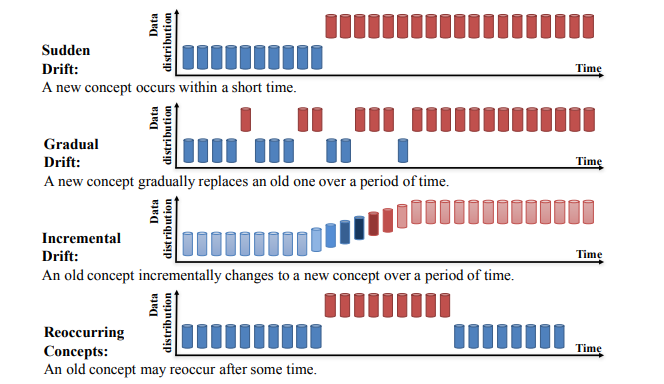

2. **Covariate shift**: This occurs when there is a change in the input data itself without an accompanying change in the output data.

Several *methods and metrics* can help detect data drift in machine learning, including data quality evaluations, the Kolmogorov-Smirnov Test, Chi-Square Test, Population Stability Index, Earth-Mover Distance, Kullback-Leibler Divergence, and Jensen-Shannon Divergence, among others. In the field of Natural Language Processing (NLP), it's particularly important to monitor input text data for signs of drift. Moreover, manually labeling a test set of data serves as a valuable quality control measure, allowing for the assessment of the model's ongoing performance and facilitating timely adjustments to mitigate the impact of data drift.

In this tutorial, we'll recreate a real scenario where we will monitor a sentiment classifier model trained on a dataset of video game reviews. We'll simulate and analyze data drift by testing new reviews and analyzing the impact of these changes on the model's performance.

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/login?next=%2Fnew-space%3Ftemplate%3Dargilla%2Fargilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or a Jupyter Notebook tool of your choice.
</div>

## Set up the Environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
# %pip install --upgrade pip
%pip install argilla -qqq
%pip install datasets
%pip install transformers
%pip install ollama

# Optional packages for further analysis
%pip install bertopic
%pip install textdescriptives
%pip install seaborn

Let's make the needed imports:

In [ ]:
import re
import pandas as pd
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import pipeline
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import textdescriptives as td

import argilla as rg
from argilla.feedback import TrainingTask, ArgillaTrainer

import ollama

nltk.download('punkt')
nltk.download('stopwords')

If you are running Argilla using the Docker quickstart image or a public Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [2]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="argilla.apikey",
    workspace="argilla"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Preparing the Data

To simulate data drift, we'll use the [LoganKells/amazon_product_reviews_video_games](https://huggingface.co/datasets/LoganKells/amazon_product_reviews_video_games) dataset, which contains reviews of video games from Amazon with their corresponding ratings and timestamps.

In [3]:
# Load the dataset
hf_dataset_games = load_dataset("LoganKells/amazon_product_reviews_video_games", split= "train[:10000]")

In [4]:
hf_dataset_games

Dataset({
    features: ['Unnamed: 0', 'reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime'],
    num_rows: 10000
})

First, we'll make some preprocessing of the data to keep the needed columns: the review of the game, the given rating, and the date.

In [5]:
# Convert to a pandas dataframe
df_games = hf_dataset_games.to_pandas()

# Convert the UnixReviewTime to a datetime
df_games['datetime'] = pd.to_datetime(df_games['unixReviewTime'], unit='s')

# Select the columns we want to keep
df_games = df_games[["reviewText", "overall", "datetime"]]
df_games = df_games.rename(columns={"reviewText": "review", "overall": "rating"})
df_games.head()

,review,rating,datetime
0,Installing the game was a struggle (because of...,0.0,2012-07-09
1,If you like rally cars get this game you will ...,3.0,2013-06-30
2,1st shipment received a book instead of the ga...,0.0,2014-06-28
3,I had Dirt 2 on Xbox 360 and it was an okay ga...,3.0,2011-06-14
4,"Overall this is a well done racing game, with ...",3.0,2013-05-11


Then, we'll divide our dataset into two parts: the reference dataset, that is the historical data on which the model would have learnt, and the current dataset, the new data we want to test. We'll simulate that our model was trained on reviews from 1999 to 2004, but now we're testing it on reviews from 2010 to 2014.

In [6]:
# Divide the dataset into two parts
ref_year = 2005
curr_year = 2010
df_reference = df_games[df_games['datetime'].dt.year < ref_year]
df_current = df_games[df_games['datetime'].dt.year >= curr_year]

print(f"Reference dataset: {df_reference.shape[0]} reviews")
print(f"Current dataset: {df_current.shape[0]} reviews")

Reference dataset: 4705 reviews
Current dataset: 3443 reviews


We'll also define some variables and create some functions to help us in the following sections.

In [7]:
# To create a feedback dataset
def create_feedback_dataset():
    dataset = rg.FeedbackDataset.for_text_classification(
        labels=["very-positive", "positive", "neutral", "negative", "very-negative"],
        multi_label=False,
        use_markdown=True,
        guidelines=None,
        metadata_properties=[
            rg.TermsMetadataProperty(
            name="datetime",
            title="Datetime",
        )],
        vectors_settings=None,
    )
    return dataset

In [8]:
# To convert the rating to a label
id2label = {0.0: "very-negative", 1.0: "negative", 2.0: "neutral", 3.0: "positive", 4.0: "very-positive"}

In [9]:
# Lists to store the first 300 reviews and datetimes
ref_reviews = df_reference["review"].head(300).tolist()
ref_datetime = df_reference["datetime"].head(300).tolist()

curr_reviews = df_current["review"].head(300).tolist()
curr_datetime = df_current["datetime"].head(300).tolist()

## Fine-tuning the Original Model

Let's say that we're currently fine-tuning a sentiment classifier model to predict the sentiment of video game reviews. So, following the common workflow, we create a `FeedbackDataset` to use our data and fine-tune the model that we'll be using in the coming years. The data used to fine-tune are the 4705 reviews from 1999 to 2004.

> The training can take some time to complete, so you can modify the [trainer parameters](../../../practical_guides/fine_tune.md#training-configs) to make it faster or use a smaller dataset.

In [ ]:
# Create the feedback dataset
ref_rg_ds = create_feedback_dataset()

records = [
    rg.FeedbackRecord(
        fields={"text": row["review"]},
        responses=[
            {
                "values": {
                    "label": {
                        "value": id2label[row["rating"]]
                    }
                }
            }
        ],
        metadata={
            "datetime": str(row["datetime"])
        }
    )
    for _ , row in df_reference.iterrows()
]

ref_rg_ds.add_records(records)
ref_rg_ds.push_to_argilla(name="reference_dataset", workspace="argilla")

In [ ]:
# Fine-tune the model
task = TrainingTask.for_text_classification(
    text=ref_rg_ds.field_by_name("text"),
    label=ref_rg_ds.question_by_name("label"),
    label_strategy=None
)

trainer = ArgillaTrainer(
    dataset=ref_rg_ds,
    task=task,
    framework="transformers",
    train_size=0.8,
)

trainer.train(output_dir="model-drift-simulation")

{'eval_loss': 0.8788877129554749, 'eval_accuracy': 0.6354941551540914, 'eval_runtime': 944.7263, 'eval_samples_per_second': 0.996, 'eval_steps_per_second': 0.125, 'epoch': 1.0}
{'train_runtime': 10846.666, 'train_samples_per_second': 0.347, 'train_steps_per_second': 0.043, 'train_loss': 1.072760642302517, 'epoch': 1.0}


Observe the model's performance on the validation dataset. If the results meet our criteria for quality, we can proceed to deploy the model in a production environment. In our case, we will imagine that the performance is good enough.

## Simulating Data Drift

We'll imagine that we have moved on to five years later. We have used our model for this time, but now the data has changed. We'll simulate this change by using the recently available [Gemma](https://ollama.com/library/gemma:latest) model, a new open model developed by Google and its DeepMind team, from `Ollama` to generate the new reviews. As a periodical task, the evaluation of the model's performance will be made on a small test, so we will use the first 300 new reviews from 2010 to 2014.

> Ollama allows you to run LLMs locally on MacOs, Windows, and Linux. Check the [official documentation]((https://ollama.com/)) for more details.

> Note that this process can take a while, optionally you can skip this step and download the created dataset.
> ```python
> dataset = load_dataset("sdiazlor/data-drift-simulation-dataset")
>```


We'll write a system prompt to define the task to perform by the model and use it to generate the new reviews. In addition, we'll change the parameters of the model to make it more creative and generate more diverse reviews.

In [ ]:
modelfile='''
FROM gemma:7b-instruct
SYSTEM You are a professional video game reviewer. Your job is to write a new and ambiguous video game review inspired by the given one. Please provide the new review that is within 128 tokens, ensuring that no sentences are left incomplete. Directly provide the new review without any other information.
'''

ollama.create(model='data-drift-simulator', modelfile=modelfile)

In [27]:
# Example of using the model
response = ollama.generate(
    model='data-drift-simulator',
    prompt="Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be 'unlocked' by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don\'t like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I\'m really tired of arcade style rally/racing games anyway.I\'ll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.",
    options={'num_predict':128}
    )
print(response["response"])

## Codemasters Rally - A Mixed Bag of Laps and Lameness

If you're in the market for a rally racer that'll have you slinging gravel and leaving your friends in the dust, Codemasters Rally might be... well... a bit of a mess.

Installing this game was a battle, thanks to the ever-present Windows Live bugs. And what's even more infuriating is that some championship races and cars are locked behind paywalls, demanding extra dough just to keep playing. I coughed up nearly $30 when the game was new, and I'm not thrilled about having to keep shelling out


In [ ]:
# List to save the rewritten reviews
rewritten_reviews = []

# Define the initial parameters
temperature = 0.5
mirostat_tau = 6.0
num_predict = 128
top_k = 40
top_p = 0.95

# Iterate over the reviews
for i, review in enumerate(curr_reviews):
    print(f"Processing review {i+1} of {len(curr_reviews)}")
    
    if i % 100 == 0 and i > 0:
        temperature += 0.1
        top_k += 10
        print(f"Temperature: {temperature}, Top K: {top_k}")

    response = ollama.generate(
        model='data-drift-simulator',
        prompt=review,
        options={
            'temperature': temperature,
            'mirostat_tau': mirostat_tau,
            'num_predict': num_predict,
            'top_k': top_k,
            'top_p': top_p
        }
    )
    print(response['response'])
    rewritten_reviews.append(response['response'])

In [33]:
# Add the rewritten reviews to the current dataframe
df_current_test = df_current.head(300)
df_current_test["rewritten_reviews"] = rewritten_reviews

In [34]:
df_current_test.head()

,review,rating,datetime,rewritten_reviews
0,Installing the game was a struggle (because of...,0.0,2012-07-09,## The Racing Game That Doesn't Race\n\nThis g...
1,If you like rally cars get this game you will ...,3.0,2013-06-30,## The Pit Stop\n\nIf you're a petrolhead with...
2,1st shipment received a book instead of the ga...,0.0,2014-06-28,## The Last Hope: A Review\n\nThe Last Hope ar...
3,I had Dirt 2 on Xbox 360 and it was an okay ga...,3.0,2011-06-14,## Racing Horizon\n\nThe wind whirs through yo...
4,"Overall this is a well done racing game, with ...",3.0,2013-05-11,## Dirt 2: The Racing Game That Eats Controlle...


## Monitoring Data Drift

### Monitoring with Argilla

In our established workflow, we continued using our model to predict outcomes on the newly acquired data. Monitoring the model's performance is integral to our quality control process, ensuring its precision remains consistent. To maintain the quality of the model's predictions on this new data, we will implement Argilla.

Thus, we start by making some predictions with our model on the first 300 new (and rewritten) reviews.

In [35]:
# Generate the predictions for the rewritten reviews
classifier = pipeline("text-classification", model="model-drift-simulation")

# Assuming current_df is your DataFrame with a column named 'text'
texts = df_current_test['rewritten_reviews']

# Initialize lists to store labels and scores
labels = []
scores = []

# Iterate over each text in the DataFrame and make predictions
for text in texts:
    prediction = classifier(text)
    labels.append(prediction[0]['label'])
    scores.append(prediction[0]['score'])

# Add the predicted labels and scores as new columns to the original DataFrame
df_current_test['predicted_label'] = labels
df_current_test['predicted_score'] = scores
df_current_test.head()

,review,rating,datetime,rewritten_reviews,predicted_label,predicted_score
0,Installing the game was a struggle (because of...,0.0,2012-07-09,## The Racing Game That Doesn't Race\n\nThis g...,neutral,0.314727
1,If you like rally cars get this game you will ...,3.0,2013-06-30,## The Pit Stop\n\nIf you're a petrolhead with...,very-positive,0.529094
2,1st shipment received a book instead of the ga...,0.0,2014-06-28,## The Last Hope: A Review\n\nThe Last Hope ar...,neutral,0.278454
3,I had Dirt 2 on Xbox 360 and it was an okay ga...,3.0,2011-06-14,## Racing Horizon\n\nThe wind whirs through yo...,very-positive,0.788434
4,"Overall this is a well done racing game, with ...",3.0,2013-05-11,## Dirt 2: The Racing Game That Eats Controlle...,positive,0.496734


For our records, we will consider the rating as the actual label of the review provided by the annotators, while the suggested label will represent our model's prediction. So, we create a `FeedbackDataset` and use the `Metrics` to compute the accuracy of the model on the new data.

> For more details about the metrics, check the [documentation](../../../practical_guides/collect_responses.html#model-metrics).

In [ ]:
# Create a new feedback dataset
curr_rg_ds = create_feedback_dataset()

records = [
    rg.FeedbackRecord(
        fields={"text": row["rewritten_reviews"]},
        suggestions=[
        {
            "question_name": "label",
            "value": row["predicted_label"],
            "agent": "model_drift"
        }
    ],
        responses=[
            {
                "values": {
                    "label": {
                        "value": id2label[row["rating"]]
                    }
                }
            }
        ],
        metadata={
            "datetime": str(row["datetime"])
        }
    )
    for _ , row in df_current_test.iterrows()
]

curr_rg_ds.add_records(records)
curr_rg_ds.push_to_argilla(name="current_dataset", workspace="argilla")

In [37]:
# Compute the model metrics
model_metrics_unified = curr_rg_ds.compute_model_metrics(question_name="label", metric_names=["accuracy", "precision", "recall", "f1-score", "confusion-matrix"], strategy="majority")
model_metrics_unified

[ModelMetricResult(metric_name='accuracy', count=300, result=0.5533333333333333),
 ModelMetricResult(metric_name='precision', count=300, result=0.2532811059907834),
 ModelMetricResult(metric_name='recall', count=300, result=0.2772412030631758),
 ModelMetricResult(metric_name='f1-score', count=300, result=0.2559887955182073),
 ModelMetricResult(metric_name='confusion-matrix', count=300, result=                         suggestions_negative  suggestions_neutral  \
 responses_negative                          1                    2   
 responses_neutral                           1                    3   
 responses_positive                          0                    4   
 responses_very-negative                     6                    6   
 responses_very-positive                     0                    9   
 
                          suggestions_positive  suggestions_very-negative  \
 responses_negative                          3                          0   
 responses_neutral     

We can observe that the model's accuracy has decreased, which is a sign of data drift. So now we are aware that there is a problem and we must analyze the data. For this, there are several possibilities and we will demonstrate two of them.

### Option 1: Analyzing Data Drift Using BerTopic

Topic modeling can be very useful to determine the main topics of the reviews and to compare them between the reference and current datasets. For the data to be balanced, we will use the 300 first samples from each of the datasets. We'll preprocess the data and use the `BerTopic` model.

>For more information, on how to use BerTopic, check the [official documentation](https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html)

In [38]:
# Function to clean the text data
def clean_review(review):
    review = review.lower()
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    
    tokens = word_tokenize(review)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_review = ' '.join(tokens)
    
    return cleaned_review

# Clean the list of reviews
cleaned_ref_reviews = [clean_review(review) for review in ref_reviews]
cleaned_rew_reviews = [clean_review(review) for review in rewritten_reviews]

In [39]:
# Join the data so that it can be visualized over time
total_reviews = cleaned_ref_reviews + cleaned_rew_reviews
total_datetime = ref_datetime + curr_datetime

In [42]:
# Fit the model
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(total_reviews)

topics_over_time = topic_model.topics_over_time(total_reviews, total_datetime, nr_bins=20)

2024-03-14 22:30:44,145 - BERTopic - Embedding - Transforming documents to embeddings.


2024-03-14 22:31:06,262 - BERTopic - Embedding - Completed ✓
2024-03-14 22:31:06,264 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-14 22:31:10,195 - BERTopic - Dimensionality - Completed ✓
2024-03-14 22:31:10,199 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-14 22:31:10,253 - BERTopic - Cluster - Completed ✓
2024-03-14 22:31:10,263 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-14 22:31:10,411 - BERTopic - Representation - Completed ✓


If we visualize the topics over time, we can see that the topics have changed. This is a clear sign of data drift.

In [43]:
# Visualize the topics over time
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

### Option 2: Analyzing Data Drift Using TextDescriptives

Data statistics is another way to analyze data drift. We can use `TextDescriptives` to compare the statistics of the reference and current datasets.

>For more information, on how to use TextDescriptives, check the [documentation](https://hlasse.github.io/TextDescriptives/). Note that Argilla also has an integration to [add text descriptives as metadata](https://docs.v1.argilla.io/en/latest/tutorials_and_integrations/integrations/add_text_descriptives_as_metadata.html).

In [44]:
# Create a dataframe with all the data over time
data = {
    'datetime': total_datetime,
    'text': ref_reviews + rewritten_reviews
}
df_curr_ref = pd.DataFrame(data)

# Extract the metrics
metrics = td.extract_metrics(
    text=df_curr_ref["text"],
    spacy_model="en_core_web_sm",
    metrics=["descriptive_stats"],
)

# Join the metrics with the original dataframe and drop the NaN values
metrics_df = df_curr_ref.join(metrics.drop(columns=["text"]))
metrics_df.dropna(inplace=True)

Using the `seaborn` library, we can visualize the statistics of the reference and current datasets. We can observe that the statistics have changed, which is another sign of data drift.

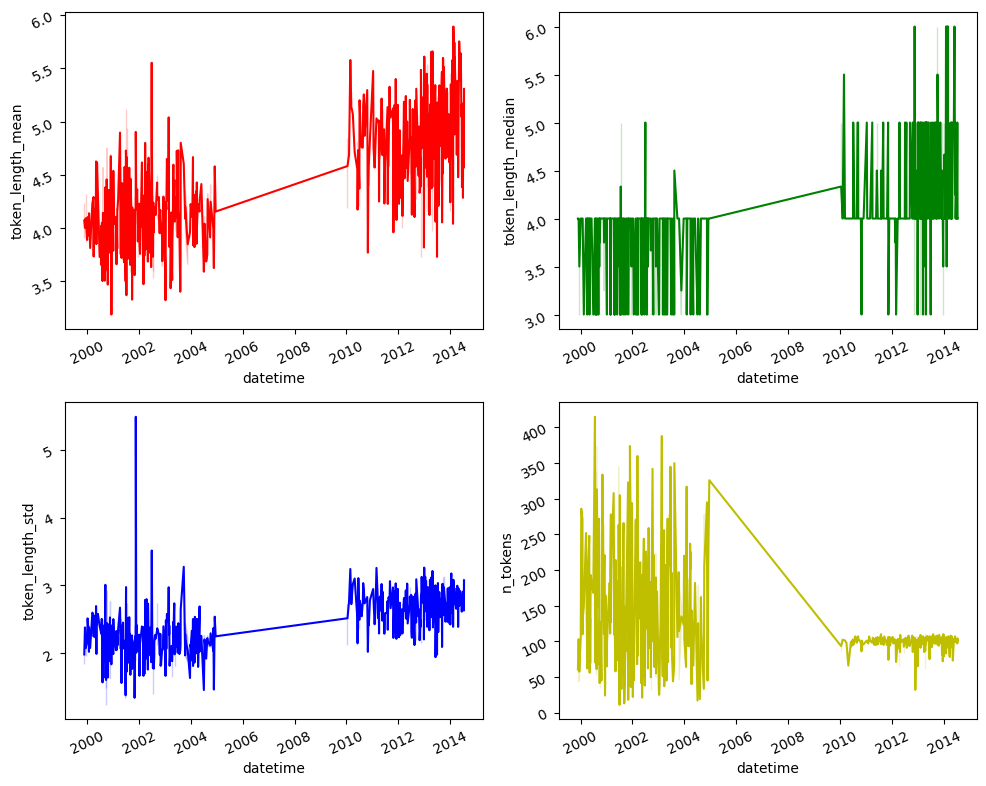

In [45]:
# Create the time series subplots 
fig,ax = plt.subplots( 2, 2, 
					figsize = ( 10, 8)) 

sns.lineplot( x = "datetime", y = "token_length_mean", 
			color = 'r', data = metrics_df, 
			ax = ax[0][0]) 

ax[0][0].tick_params(labelrotation = 25) 
sns.lineplot( x = "datetime", y = "token_length_median", 
			color = 'g', data = metrics_df, 
			ax = ax[0][1]) 

ax[0][1].tick_params(labelrotation = 25) 
sns.lineplot(x = "datetime", y = "token_length_std", 
			color = 'b', data = metrics_df, 
			ax = ax[1][0]) 

ax[1][0].tick_params(labelrotation = 25) 

sns.lineplot(x = "datetime", y = "n_tokens", 
			color = 'y', data = metrics_df, 
			ax = ax[1][1]) 

ax[1][1].tick_params(labelrotation = 25) 
fig.tight_layout(pad = 1.2) 

## Conclusions

In this tutorial, we have created a simulation of a real-world scenario where we train a sentiment classifier model on a dataset of video game reviews. Over time, as we apply this model to ongoing data, a routine quality control check (with the simulated current data generated by `gemma`) using `Argilla` reveals a decline in the model's accuracy. To diagnose the issue, we examine the data and discover shifts in topics and statistics, indicating data drift. This analysis is conducted using tools like `BerTopic` and `TextDescriptives` to identify and understand the changes. So, we have learned how to effectively monitor data drift using different tools and how to analyze the impact of these changes on the model's performance.